In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
anr_tag = 'NOAK'
wacc = utils.WACC
cambium_scenario = 'MidCase'
year = 2024
results_path = f'./results/raw_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'
clean_save_path = f'./results/clean_results_anr_{anr_tag}_h2_wacc_{str(wacc)}.xlsx'


In [3]:
save_fig_path = './results/ammonia_anr_'+anr_tag+'_h2'

In [4]:
df = pd.read_excel(results_path, sheet_name='ammonia')
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df.columns

Index(['id', 'state', 'State price ($/MMBtu)', 'latitude', 'longitude',
       'Ammonia capacity (tNH3/year)', 'H2 Dem. (kg/day)', 'ANR CAPEX ($/MWe)',
       'Aux Elec Dem. (MWe)', 'Net Revenues ($/year)',
       'H2 PTC Revenues ($/year)', 'Net Revenues with H2 PTC ($/year)', 'PEM',
       'Alkaline', 'HTSE', 'Ann. CO2 emissions (kgCO2eq/year)',
       'Initial investment ($)', 'ANR CAPEX ($/year)', 'ANR CRF',
       'Depl. ANR Cap. (MWe)', 'Depl H2 Cap. (MWe)', 'H2 CAPEX ($/year)',
       'ANR O&M ($/year)', 'H2 O&M ($/year)', 'Conversion costs ($/year)',
       'Avoided NG costs ($/year)', 'Breakeven price ($/MMBtu)',
       'BE wo PTC ($/MMBtu)', 'Breakeven CAPEX ($/MWe)', 'Cost red CAPEX BE',
       'Surplus ANR Cap. (MWe)', 'Net Annual Revenues ($/MWe/y)',
       'Net Annual Revenues with H2 PTC ($/MWe/y)', 'ANR type',
       '# ANR modules'],
      dtype='object')

In [5]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name=anr_tag)

### Cumulative number of viable ammonia plants and ANR modules

In [6]:
anr_thermal_power = anr_param[['Power in MWt', 'Power in MWe', 'Reactor']]
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['Deployed Power (MWe)'] = df['Power in MWe']*df['# ANR modules']
df['ANR Nameplate Capacity (GWe)'] = df['Deployed Power (MWe)'].cumsum()/1000
df['Cum h2 dem (t/day)'] =df['H2 Dem. (kg/day)'].cumsum()/1000
df['Cum h2 dem (%)'] = 100*df['H2 Dem. (kg/day)'].cumsum()/df['H2 Dem. (kg/day)'].sum()
df.tail(10)

,id,state,State price ($/MMBtu),latitude,longitude,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),ANR CAPEX ($/MWe),Aux Elec Dem. (MWe),Net Revenues ($/year),...,ANR type,# ANR modules,Power in MWt,Power in MWe,Reactor,Deployed Power (MWt),Deployed Power (MWe),ANR Nameplate Capacity (GWe),Cum h2 dem (t/day),Cum h2 dem (%)
24,Co_E.,IL,5.119415,42.492225,-90.642905,350000,483970.750863,3655200,0.198107,-1.685284e+08,...,PBR-HTGR,6,200,80.0,PBR-HTGR,1200,480.0,22.2080,23624.686510,94.564676
25,Dy_Ch,WY,4.792571,41.139981,-104.820246,175000,241985.375431,3655200,0.099053,-8.827565e+07,...,PBR-HTGR,3,200,80.0,PBR-HTGR,600,240.0,22.4480,23866.671885,95.533293
26,Ko_Fo,IA,4.584279,42.504402,-94.191004,340000,470143.015124,3655200,0.192447,-1.746007e+08,...,PBR-HTGR,6,200,80.0,PBR-HTGR,1200,480.0,22.9280,24336.814901,97.415177
27,LS_Ch,AL,4.636387,34.114255,-85.600451,170000,235071.507562,3655200,0.096223,-8.931876e+07,...,PBR-HTGR,3,200,80.0,PBR-HTGR,600,240.0,23.1680,24571.886408,98.356119
28,Ne_Ge,NE,4.584279,40.525754,-97.602767,90000,124449.621650,3272800,0.050942,-4.900279e+07,...,iMSR,1,300,141.0,iMSR,300,141.0,23.3090,24696.336030,98.854265
29,Au_Gr,TN,4.636387,36.163157,-82.830986,60000,82966.414434,3655200,0.033961,-3.266580e+07,...,PBR-HTGR,1,200,80.0,PBR-HTGR,200,80.0,23.3890,24779.302444,99.186362
30,U._Mo,TN,4.636387,36.189544,-82.958490,60000,82966.414434,3655200,0.033961,-3.266580e+07,...,PBR-HTGR,1,200,80.0,PBR-HTGR,200,80.0,23.4690,24862.268859,99.518459
31,Gr_Cr,IA,4.584279,41.058588,-94.361397,32000,44248.754365,8721600,0.018113,-3.062624e+07,...,Micro,5,20,6.7,Micro,100,33.5,23.5025,24906.517613,99.695578
32,Ch_El,CA,5.680861,33.917028,-118.415634,25000,34569.339347,8721600,0.014150,-2.456903e+07,...,Micro,4,20,6.7,Micro,80,26.8,23.5293,24941.086952,99.833951
33,Sh_Go,GA,5.097354,34.501965,-84.898631,30000,41483.207217,8721600,0.016981,-3.022063e+07,...,Micro,5,20,6.7,Micro,100,33.5,23.5628,24982.570160,100.000000


In [7]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR ammonia plants count'] = df.index+1
df.tail(10)

,id,state,State price ($/MMBtu),latitude,longitude,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),ANR CAPEX ($/MWe),Aux Elec Dem. (MWe),Net Revenues ($/year),...,Power in MWt,Power in MWe,Reactor,Deployed Power (MWt),Deployed Power (MWe),ANR Nameplate Capacity (GWe),Cum h2 dem (t/day),Cum h2 dem (%),Viable ANR modules count,Viable ANR ammonia plants count
24,Co_E.,IL,5.119415,42.492225,-90.642905,350000,483970.750863,3655200,0.198107,-1.685284e+08,...,200,80.0,PBR-HTGR,1200,480.0,22.2080,23624.686510,94.564676,180,25
25,Dy_Ch,WY,4.792571,41.139981,-104.820246,175000,241985.375431,3655200,0.099053,-8.827565e+07,...,200,80.0,PBR-HTGR,600,240.0,22.4480,23866.671885,95.533293,183,26
26,Ko_Fo,IA,4.584279,42.504402,-94.191004,340000,470143.015124,3655200,0.192447,-1.746007e+08,...,200,80.0,PBR-HTGR,1200,480.0,22.9280,24336.814901,97.415177,189,27
27,LS_Ch,AL,4.636387,34.114255,-85.600451,170000,235071.507562,3655200,0.096223,-8.931876e+07,...,200,80.0,PBR-HTGR,600,240.0,23.1680,24571.886408,98.356119,192,28
28,Ne_Ge,NE,4.584279,40.525754,-97.602767,90000,124449.621650,3272800,0.050942,-4.900279e+07,...,300,141.0,iMSR,300,141.0,23.3090,24696.336030,98.854265,193,29
29,Au_Gr,TN,4.636387,36.163157,-82.830986,60000,82966.414434,3655200,0.033961,-3.266580e+07,...,200,80.0,PBR-HTGR,200,80.0,23.3890,24779.302444,99.186362,194,30
30,U._Mo,TN,4.636387,36.189544,-82.958490,60000,82966.414434,3655200,0.033961,-3.266580e+07,...,200,80.0,PBR-HTGR,200,80.0,23.4690,24862.268859,99.518459,195,31
31,Gr_Cr,IA,4.584279,41.058588,-94.361397,32000,44248.754365,8721600,0.018113,-3.062624e+07,...,20,6.7,Micro,100,33.5,23.5025,24906.517613,99.695578,200,32
32,Ch_El,CA,5.680861,33.917028,-118.415634,25000,34569.339347,8721600,0.014150,-2.456903e+07,...,20,6.7,Micro,80,26.8,23.5293,24941.086952,99.833951,204,33
33,Sh_Go,GA,5.097354,34.501965,-84.898631,30000,41483.207217,8721600,0.016981,-3.022063e+07,...,20,6.7,Micro,100,33.5,23.5628,24982.570160,100.000000,209,34


### Avoided carbon emissions

In [8]:
ammonia_demand_df = pd.read_excel('./h2_demand_ammonia_us_2022.xlsx', sheet_name='processed')
df = df.merge(ammonia_demand_df, on='id')
ratio_co2_to_nh3 = 2.30 # tCO2eq/tNH3
df['NG path GHG (tCO2/year)'] = df.apply(lambda x:x['Capacity (tNH3/year)']*2.30, axis=1)

In [9]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['NG path GHG (tCO2/year)'] - (df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df[['Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']].tail(50)


,Breakeven price ($/MMBtu),Viable avoided emissions (MMT-CO2/year)
0,-31.855300,8.454601
1,-31.789030,10.635363
2,-31.463971,12.998704
3,-31.419737,13.954752
4,-31.318785,15.598401
5,-31.241656,16.081737
6,-31.150951,16.790696
7,-31.104034,17.725277
8,-30.943798,18.874747
9,-30.773474,19.787861


### Comparison against RES

In [10]:
df[['Breakeven price ($/MMBtu)', 'Cum h2 dem (%)']]

,Breakeven price ($/MMBtu),Cum h2 dem (%)
0,-31.855300,21.780041
1,-31.789030,27.398018
2,-31.463971,33.486467
3,-31.419737,35.949521
4,-31.318785,40.183760
5,-31.241656,41.429125
6,-31.150951,43.255659
7,-31.104034,45.663364
8,-30.943798,48.624564
9,-30.773474,50.976919


In [11]:
res_be = pd.read_csv('./results/res_be_ammonia.csv', index_col='RES')
def find_be_h2_demand(df, percentage):
  indleft = df['Cum h2 dem (%)'].sub(percentage).abs().idxmin()
  be = df['Breakeven price ($/MMBtu)'][indleft]
  return be
for percent in [10, 25, 50, 75, 90,100]:
  res_be.loc[str(percent), 'Breakeven price ($/MMBtu)'] = find_be_h2_demand(df, percent)
res_be

,Breakeven price ($/MMBtu)
RES,
Grid PEM,87.789310
Wind unsubsidized,110.147433
Wind subsidized,93.748720
Solar PEC,124.313727
Solar PV-E,127.576608
SMR 89% CCUS,33.125966
10,-31.855300
25,-31.789030
50,-30.773474


In [12]:
sheetn= 'ammonia'
excelf = './results/res_be_comparison.xlsx'
try:
  with pd.ExcelFile(excelf, engine='openpyxl') as xls:
    with pd.ExcelWriter(excelf, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
      res_be.to_excel(writer, sheet_name=sheetn)
except FileNotFoundError:
  res_be.to_excel(excelf, sheet_name=sheetn)

### Compute Revenues from Electricity Cogeneration

In [13]:
df = utils.compute_cogen(df, surplus_cap_col_name='Surplus ANR Cap. (MWe)', state_col_name='state', \
                         cambium_scenario=cambium_scenario, year = year)
df['Net Revenues with H2 PTC with elec ($/year)'] = df['Net Revenues with H2 PTC ($/year)']+df['Electricity revenues ($/y)']

### Compute IRR

In [14]:
df['IRR w PTC'] = df.apply(lambda x: utils.calculate_irr(x['Initial investment ($)'], x['Electricity revenues ($/y)'], x['H2 PTC Revenues ($/year)'], x['Avoided NG costs ($/year)']), axis=1)
df['IRR wo PTC'] = df.apply(lambda x: utils.calculate_irr(x['Initial investment ($)'], x['Electricity revenues ($/y)'], x['H2 PTC Revenues ($/year)'], x['Avoided NG costs ($/year)'], ptc=False), axis=1)
df

,id,state,State price ($/MMBtu),latitude_x,longitude_x,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),ANR CAPEX ($/MWe),Aux Elec Dem. (MWe),Net Revenues ($/year),...,Capacity (tNH3/year),H2 Dem. (kg/year),Electricity demand (MWe),NG path GHG (tCO2/year),Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year),Electricity revenues ($/y),Net Revenues with H2 PTC with elec ($/year),IRR w PTC,IRR wo PTC
0,CF_Do,LA,4.096007,30.105194,-90.987592,3935000,5.441214e+06,3272800,2.227288,-1.605274e+09,...,3935000,1.986043e+09,53.454909,9050500.0,8.454601,8.454601,2.153015e+07,4.374385e+09,0.47,-0.02
1,Ko_En,OK,4.096007,36.396762,-97.879134,1015000,1.403515e+06,3272800,0.574510,-4.161401e+08,...,1015000,5.122830e+08,13.788242,2334500.0,2.180762,10.635363,2.911911e+06,1.123621e+09,0.46,-0.03
2,CF_Ve,OK,4.096007,36.234820,-95.691093,1100000,1.521051e+06,3272800,0.622622,-4.620094e+08,...,1100000,5.551836e+08,14.942922,2530000.0,2.363341,12.998704,9.495962e+06,1.213037e+09,0.46,-0.02
3,LS_El,AK,5.680861,64.843286,-147.719295,445000,6.153342e+05,3272800,0.251879,-1.657743e+08,...,445000,2.245970e+08,6.045091,1023500.0,0.956048,13.954752,3.830015e+06,5.118467e+08,0.47,0.00
4,Nu_Au,GA,5.097354,33.470971,-81.974843,765000,1.057822e+06,3272800,0.433005,-3.011206e+08,...,765000,3.861050e+08,10.392123,1759500.0,1.643649,15.598401,1.243442e+07,8.696287e+08,0.46,-0.00
5,LS_Pr,OK,4.096007,36.308428,-95.316914,225000,3.111241e+05,3272800,0.127354,-9.604356e+07,...,225000,1.135603e+08,3.056507,517500.0,0.483336,16.081737,6.471494e+05,2.452844e+08,0.44,-0.03
6,OC_Be,TX,4.096007,30.086046,-94.101846,330000,4.563153e+05,3272800,0.186787,-1.417864e+08,...,330000,1.665551e+08,4.482877,759000.0,0.708958,16.790696,3.102877e+06,3.609817e+08,0.44,-0.03
7,CF_Wo,OK,4.096007,36.374499,-99.245538,435000,6.015065e+05,3272800,0.246219,-1.875293e+08,...,435000,2.195499e+08,5.909247,1000500.0,0.934581,17.725277,4.918689e+06,4.760390e+08,0.44,-0.03
8,Nu_Ge,LA,4.096007,30.204363,-91.022601,535000,7.397839e+05,3272800,0.302821,-2.332815e+08,...,535000,2.700211e+08,7.267694,1230500.0,1.149470,18.874747,1.236663e+07,5.891484e+08,0.44,-0.02
9,Co_Co,KS,4.584279,37.037300,-95.616363,425000,5.876788e+05,3272800,0.240558,-1.811525e+08,...,425000,2.145028e+08,5.773402,977500.0,0.913114,19.787861,7.879498e+06,4.702353e+08,0.44,-0.01


### Save

In [15]:
df.columns

Index(['id', 'state', 'State price ($/MMBtu)', 'latitude_x', 'longitude_x',
       'Ammonia capacity (tNH3/year)', 'H2 Dem. (kg/day)', 'ANR CAPEX ($/MWe)',
       'Aux Elec Dem. (MWe)', 'Net Revenues ($/year)',
       'H2 PTC Revenues ($/year)', 'Net Revenues with H2 PTC ($/year)', 'PEM',
       'Alkaline', 'HTSE', 'Ann. CO2 emissions (kgCO2eq/year)',
       'Initial investment ($)', 'ANR CAPEX ($/year)', 'ANR CRF',
       'Depl. ANR Cap. (MWe)', 'Depl H2 Cap. (MWe)', 'H2 CAPEX ($/year)',
       'ANR O&M ($/year)', 'H2 O&M ($/year)', 'Conversion costs ($/year)',
       'Avoided NG costs ($/year)', 'Breakeven price ($/MMBtu)',
       'BE wo PTC ($/MMBtu)', 'Breakeven CAPEX ($/MWe)', 'Cost red CAPEX BE',
       'Surplus ANR Cap. (MWe)', 'Net Annual Revenues ($/MWe/y)',
       'Net Annual Revenues with H2 PTC ($/MWe/y)', 'ANR type',
       '# ANR modules', 'Power in MWt', 'Power in MWe', 'Reactor',
       'Deployed Power (MWt)', 'Deployed Power (MWe)',
       'ANR Nameplate Capacity (GWe)

In [16]:
df_clean = df[["id", 'state', 'latitude_x', 'longitude_x','Capacity (tNH3/year)', 'H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', \
               'Net Revenues ($/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven price ($/MMBtu)', 'Breakeven CAPEX ($/MWe)', 'Cost red CAPEX BE',\
                'Electricity revenues ($/y)','Net Revenues with H2 PTC with elec ($/year)',\
                'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)', 'Net Revenues with H2 PTC ($/year)']]
df_clean['H2 Dem. (kg/day)'] /=1e3

df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))

df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x,1))

df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Revenues ($/year)']/(1e6*df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'])
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))

df_clean['Net Revenues ($/year)'] = df_clean['Net Revenues ($/year)'].apply(lambda x: np.round(x/1e6,1))

df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))

df_clean['Breakeven price ($/MMBtu)'] = df_clean['Breakeven price ($/MMBtu)'].apply(lambda x : np.round(x,1))

df_clean.rename(columns={'H2 Dem. (kg/day)': 'Demand (MT H2/day)',
                         'Net Rev. ($/year)': 'Net Rev. (M$/year)', 
                         'ANR type': 'ANR', 
                         'latitude_x':'latitude', 'longitude_x':'longitude',
                         '# ANR modules': '#'}, inplace=True)
df.rename(columns={'latitude_x':'latitude', 'longitude_x':'longitude'}, inplace=True)

In [17]:
sheet_name = 'ammonia'
excel_file = clean_save_path
try:
# Load the existing Excel file
  with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
      with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
              df.to_excel(writer, sheet_name=sheet_name)
except FileNotFoundError:
    # If the file doesn't exist, create a new one and write the DataFrame to it
    df.to_excel(excel_file, sheet_name=sheet_name)

### Plots

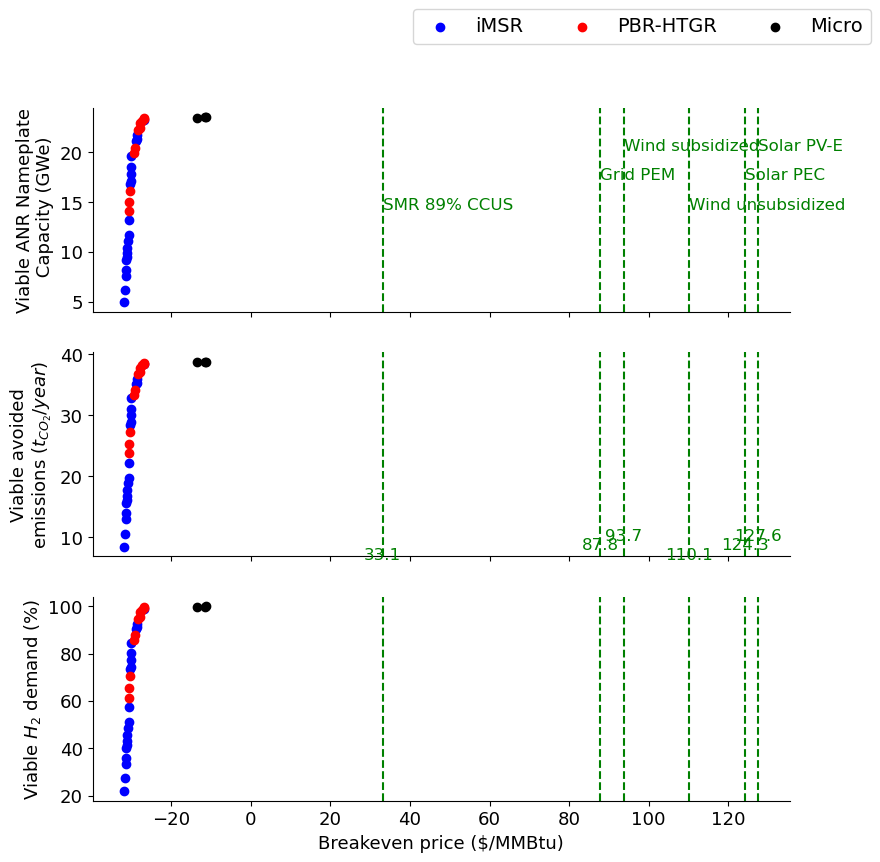

In [18]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 13

# Create subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 9))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWe)': 'Viable ANR Nameplate\n Capacity (GWe)',
            'Viable avoided emissions (MMT-CO2/year)': 'Viable avoided\n'r'emissions ($t_{CO_2}/year$)',
            'Cum h2 dem (%)':r'Viable $H_2$ demand (%)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWe)', 'Viable avoided emissions (MMT-CO2/year)', 'Cum h2 dem (%)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


    # Adding vertical lines
    res_be = pd.read_csv('./results/res_be_ammonia.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)

    #ng_vertical_lines = [6.4, 13, 40]
    #ng_labels = ['US NG\navg 2022', 'CA NG\ndelivered 2022', 'EU NG\n 2022']
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    #for line in ng_vertical_lines:
     #   axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+3*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x, axs[1].get_ylim()[0]+1.5*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path+'.png')

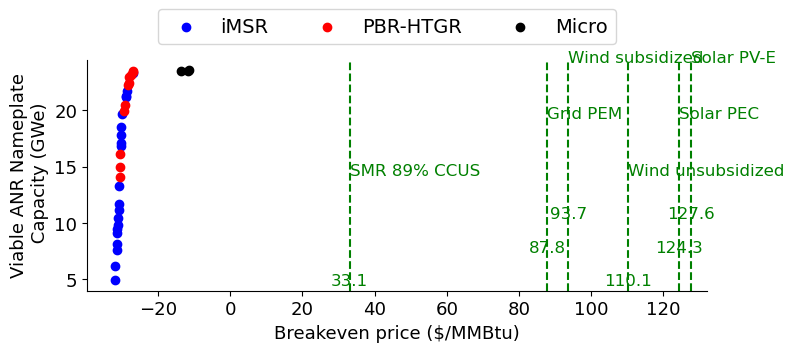

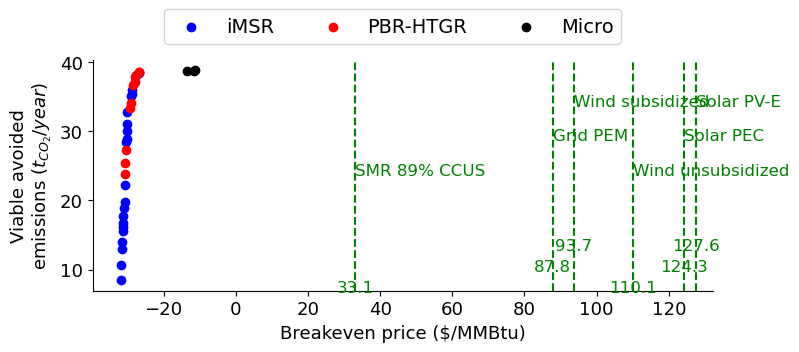

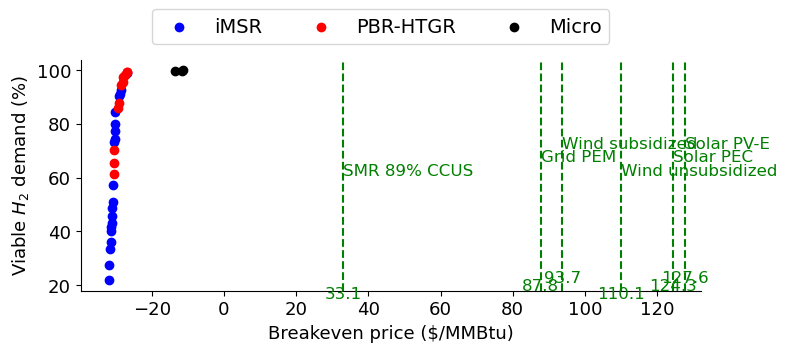

In [19]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.size'] = 13
labels = {'ANR Nameplate Capacity (GWe)': ['Viable ANR Nameplate\n Capacity (GWe)', 'capacity'],
            'Viable avoided emissions (MMT-CO2/year)': ['Viable avoided\n'r'emissions ($t_{CO_2}/year$)', 'emission'],
            'Cum h2 dem (%)':[r'Viable $H_2$ demand (%)', 'h2_demand']}

def plot_against_be(df, col_name, y_label, save_label):
    anr_types = df['ANR type'].unique()
    colors = ['blue', 'red', 'black'] 
    fig, axs = plt.subplots(figsize=(8, 3))
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs.scatter(subset['Breakeven price ($/MMBtu)'], subset[col_name], color=color, label=f'{anr_type}')
    axs.set_ylabel(y_label)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)

    # Adding vertical lines and labels for competing RES 
    res_be = pd.read_csv('./results/res_be_ammonia.csv')
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    for l,line in enumerate(res_vert_lines):
        axs.axvline(x=line, linestyle='--',color='green')
        res_labels = res_be['RES']
    count = 0
    for x, label in zip(res_vert_lines, res_labels):
        axs.text(x, (axs.get_ylim()[1]+axs.get_ylim()[0])/2+5*np.mod(count,3), label, fontsize=12, color='green')
        axs.text(x, axs.get_ylim()[0]+3*np.mod(count,3)+1.5, str(x), color='green', fontsize=12, va='top',ha='center')
        count+=1
        # Setting the title and labels
    axs.set_xlabel('Breakeven price ($/MMBtu)')
    handles, labels = axs.get_legend_handles_labels()
    fig.legend(handles, labels,  bbox_to_anchor=(.5,1.08),loc='upper center', ncol=len(anr_types))

    fig.savefig(save_fig_path+'_'+save_label+'.png', bbox_inches='tight')

for col_name, label_list in labels.items():
    plot_against_be(df, col_name, y_label=label_list[0], save_label=label_list[1])
